# Install dependencies and create functions - please store the QDRANT-API-KEY

In [1]:
!pip install qdrant_client

ERROR: Operation cancelled by user


In [2]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, Filter, FieldCondition, MatchValue
from qdrant_client.http import models
import pandas as pd
import numpy as np
import pickle
import hashlib
import uuid
from google.colab import userdata, auth
from google.cloud import storage
import io
import matplotlib.pyplot as plt
import os
import pickle


### Functions to create collection and upload data to QDRANT

def create_collection(q_drant_client,collection_name,embedding_size,distance=Distance.COSINE):
    """Creates a quadrant collection within a Qdrant-DB

    Args:
        q_drant_client (qdrant_client.QdrantClient): qdrant-client.
        name (String): name of collection
        embedding_size (int): size of 1d-embedding
        distance (qdrant_client.http.models.Distance, optional): distance metric. Defaults to Distance.DOT.
    Returns:
        info: info about successful establishment (True == success)
    """
    info = q_drant_client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=embedding_size, distance=distance)
    )
    return info


def dict_2_qdrant_object(data,type_of_model):
    """Reads a pickle-file and transforms it into a bulk-upload-object for qdrant.

    Args:
        emb_dict (dict): embedding_dict
        type_of_model (model): either RESNET50_IMAGENET or RESNET152_IMAGENET

    Returns:
        qdrant_client.http.models.Batch: Batch-object for bulk upload
    """

    if not (type_of_model == "RESNET50_IMAGENET" or type_of_model == "RESNET152_IMAGENET"):
      print("Model type not available for now.")
      exit(1)

    # Extract the content for the bulk-object
    ids = []
    payloads = []
    vectors = []
    for key_i, values_i in data.items():
      # Meta
      meta = [{"patient_uuid":key_i},
              {"patient_id" : data[key_i]['pat_id']},
              {"bucket_url" : data[key_i]['bucket_url']},
              {"origin_ds" : data[key_i]['origin_ds']},
              {"diagnose" : data[key_i]['diagnose']}]

      # Embeddings
      meta.append({"slice_id": data[key_i]['embeddings']['slice_id']})
      for i in ['t1', 'seg_t1', 't1c', 'seg_t1c', 't2', 'seg_t2', 'flair', 'seg_flair']:
        ids.append(str(uuid.uuid4()))
        vectors.append(data[key_i]['embeddings'][type_of_model][i].tolist())
        meta_temp = meta.copy()
        meta_temp.append({"image_type": i})
        payloads.append({k: v for d in meta_temp for k, v in d.items()})

    # create models.Batch object for bulk upload to qdrant
    upload = models.Batch(
        ids=ids,
        payloads=payloads,
        vectors=vectors,
      )

    print(f"Length of ids-list {len(ids)}, payloads-list {len(payloads)}, vecotrs-list {len(vectors)} ")
    return upload


def upload_2_qdrant(qdrant_client,collection_name,upload_object):
    """Uploads qdrant-batch object to qdrant collection

    Args:
        qdrant_client (qdrant_client.QdrantClient): qdrant client
        collection_name (String): Name of qdrant-colleciton
        upload_object (qdrant_client.http.models.Batch): Batch-object for bulk upload

    Returns:
        String: Info about upload
    """
    operation_info = qdrant_client.upsert(
        collection_name=collection_name,
        wait=True,
        points=upload_object
    )

    return operation_info

def pickle_2_qdrant(google_client,qdrant_client,collection_name,bucket_name,path_to_pickle,type_of_model):
  """Upload pickles to qdrant provided that a collection already exists

    Args:
        google_client (google.cloud.storage.Client): google client
        qdrant_client (qdrant_client.QdrantClient): qdrant client
        collection_name (String): Name of qdrant-colleciton
        bucket_name (String): name of gcs bucket
        path_to_pickle (String): path to pickle inside specified bucket_name
        type_of_model (String): Type of model (RESNET50_IMAGENET/RESNET152_IMAGENET) that needs to be embedded
  """
  # Open pickle with embeddings
  bucket = google_client.get_bucket(bucket_name)
  blob = bucket.get_blob(path_to_pickle)
  raw_data = blob.download_as_bytes()
  data = pickle.loads(raw_data)
  print(f"Length of dict: {len(data)}")
  # Get upload-object
  embedding_object = dict_2_qdrant_object(data,type_of_model)
  # Upload to QDRANT.
  upload_2_qdrant(qdrant_client=qdrant_client,
                  collection_name=collection_name,
                  upload_object=embedding_object)


### Functions to interact with QDRANT


def get_similar_embeddings(qdrant_client,collection_name,search_vector,num_results,filter_diagnose=None,filter_image_type=None):
    """Gets similar embeddings according to specified distance metric. Returns num_results most similar embeddings

    Args:
        qdrant_client (qdrant_client.QdrantClient): qdrant client
        collection_name (String): Name of qdrant-colleciton
        search_vector (list): vector-list
        num_results (int): number of mist similar embeddings to be returned

    Returns:
        list: search_result
    """

    if filter_diagnose and filter_image_type:
      filter = models.Filter(
        must=[models.FieldCondition(key="image_type",match=models.MatchValue(value=filter_image_type),),],
        should=[models.FieldCondition(key="diagnose",match=models.MatchValue(value=i)) for i in filter_diagnose]
        )
    elif filter_diagnose:
      filter = models.Filter(
        should=[models.FieldCondition(key="diagnose",match=models.MatchValue(value=i)) for i in filter_diagnose]
        )
    elif filter_image_type:
      filter = models.Filter(
        must=[models.FieldCondition(key="image_type",match=models.MatchValue(value=filter_image_type),)]
        )
    else:
      filter = None

    search_result = qdrant_client.search(
        collection_name=collection_name,
        query_vector=search_vector,
        query_filter=filter,
        limit=num_results
    )

    return search_result



ModuleNotFoundError: ignored

# Upload dict to QDRANT

In [ ]:
if __name__ == "__main__":

  # Authenticate colab for GCS and get QDRANT-API-Key
  auth.authenticate_user()
  google_client = storage.Client()
  qdrant_api_key = userdata.get('qdrant_api')

  # Establish connection to QDRANT.
  qdrant_client = QdrantClient(
      url="https://e4327f42-67e1-4430-98a1-8bb0ae225101.us-east4-0.gcp.cloud.qdrant.io:6333",
      api_key=qdrant_api_key,
  )

  # Create new collection
  collection_name = "resnet152_imagenet_embeddings"

  create_collection(qdrant_client,collection_name,2048)

  embedding_pickles = ["combined_embeddings/100_ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_embeddings.pickle",
                       "combined_embeddings/100_ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_embedding.pickle",
                       "combined_embeddings/100_ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData_embedding.pickle",
                       "combined_embeddings/100_ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2_embedding.pickle",
                       "combined_embeddings/100_BraTS-MEN-Train_embedding.pickle"]

  for pickle_file in embedding_pickles:
    print(pickle_file)
    #pickle_2_qdrant(google_client,qdrant_client,collection_name,"picture_embeddings",pickle_file,"RESNET152_IMAGENET")
    print("")


combined_embeddings/100_ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData_embeddings.pickle
Length of dict: 100
Length of ids-list 800, payloads-list 800, vecotrs-list 800 

combined_embeddings/100_ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData_embedding.pickle
Length of dict: 100
Length of ids-list 800, payloads-list 800, vecotrs-list 800 

combined_embeddings/100_ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData_embedding.pickle
Length of dict: 99
Length of ids-list 792, payloads-list 792, vecotrs-list 792 

combined_embeddings/100_ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2_embedding.pickle
Length of dict: 60
Length of ids-list 480, payloads-list 480, vecotrs-list 480 

combined_embeddings/100_BraTS-MEN-Train_embedding.pickle
Length of dict: 100
Length of ids-list 800, payloads-list 800, vecotrs-list 800 



In [ ]:
#qdrant_client.delete_collection(collection_name=collection_name)
#qdrant_client.get_collection(collection_name="resnet152_imagenet_embeddings")

True

# Do similarity search -> Be aware: The following code is still Work in Progress

In [ ]:
auth.authenticate_user()
google_client = storage.Client()
qdrant_api_key = userdata.get('qdrant_api')

bucket = google_client.get_bucket("picture_embeddings")
blob = bucket.get_blob("combined_embeddings/100_ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2_embedding.pickle")
raw_data = blob.download_as_bytes()
data = pickle.loads(raw_data)

# Establish connection to QDRANT.
qdrant_client = QdrantClient(
      url="https://e4327f42-67e1-4430-98a1-8bb0ae225101.us-east4-0.gcp.cloud.qdrant.io:6333",
      api_key=qdrant_api_key,
  )

In [ ]:
import pickle
with open("resnet50_embedding_snapshot.pickle","wb") as handle:
  pickle.dump(snapshot_info, handle)

brats-image-files-eu ASNR-MICCAI-BraTS2023-SSA-Challenge-TrainingData_V2/BraTS-SSA-00230-000/png/BraTS-SSA-00230-000_t2_sliced.png


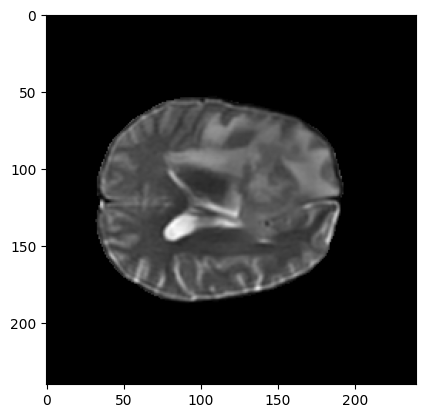

In [ ]:
from PIL import Image

bucket_url = data[list(data.keys())[-1]]["bucket_url"]
pat_id = data[list(data.keys())[-1]]["pat_id"]
query_data = data[list(data.keys())[-1]]["embeddings"]["RESNET152_IMAGENET"]["t2"].tolist()
#query_data_2 = data[list(data.keys())[-1]]["embeddings"]["RESNET152_IMAGENET"]["seg_t1"].tolist()

bucket = bucket_url.split("/")[2]
pic_url = "/".join(bucket_url.split("/")[3:-1]) + "/png/" + pat_id + "_" + "t2" + "_sliced.png"


# Show reference image
bucket_pic = google_client.get_bucket(bucket)
blob = bucket_pic.get_blob(pic_url)
image_data = blob.download_as_bytes()

image = Image.open(io.BytesIO(image_data))
plt.imshow(image,cmap="gray")
print(bucket,pic_url)

In [ ]:
collection_name = "resnet152_imagenet_embeddings"
res = get_similar_embeddings(qdrant_client=qdrant_client,
                       collection_name=collection_name,
                       search_vector=query_data,
                       filter_image_type="t1",
                       filter_diagnose=["ssa","met"],
                       num_results=100)

print([i.payload["image_type"] for i in res])
print([i.payload["diagnose"] for i in res])

['t1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 't1']
['met', 'ssa', 'ssa', 'ssa', 'ssa', 'ssa', 'ssa', 'ssa', 'ssa', 'met', 'ssa', 'met', 'ssa', 'met', 'ssa', 'ssa', 'ssa', 'ssa', 'ssa', 'met', 'met', 'ssa', 'ssa', 'met', 'met', 'ssa', 'ssa', 'ssa', 'met', 'met', 'met', 'met', 'met', 'met', 'ssa', 'met', 'ssa', 'ssa', 'ssa', 'met', 'met', 'ssa', 'met', 'met', 'ssa', 'met', 'ssa', 'met', 'met', 'met', 'ssa', 'ssa', 'ssa', 'met', 'met', 'ssa', 'met',

In [ ]:
from PIL import Image
import io

def show_image_from_qdrant_result(google_client,result,image_type):
  #image_type = res.payload["image_type"]
  bucket_url = result.payload["bucket_url"]
  pat_id = result.payload["patient_id"]

  bucket = bucket_url.split("/")[2]
  pic_url = "/".join(bucket_url.split("/")[3:-1]) + "/png/" + pat_id + "_" + image_type + "_sliced.png"

  bucket = google_client.get_bucket(bucket)
  blob = bucket.get_blob(pic_url)
  image_data = blob.download_as_bytes()

  image = Image.open(io.BytesIO(image_data))
  plt.imshow(image,cmap="gray")
  plt.show()


[ScoredPoint(id='6c034e00-a209-439f-b563-69d6bdf80568', version=1, score=0.9361329, payload={'bucket_url': 'gs://brats-image-files-eu/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData/BraTS-MET-00138-000/', 'diagnose': 'met', 'image_type': 't2', 'origin_ds': 'brats', 'patient_id': 'BraTS-MET-00138-000', 'patient_uuid': '679b75fe-64a7-4f2e-90d4-96a4ea17304a', 'slice_id': 78}, vector=None), ScoredPoint(id='8dc06a6d-07af-46b1-af82-9d485769cc5f', version=1, score=0.93417966, payload={'bucket_url': 'gs://brats-image-files-eu/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData/BraTS-MET-00002-000/', 'diagnose': 'met', 'image_type': 't2', 'origin_ds': 'brats', 'patient_id': 'BraTS-MET-00002-000', 'patient_uuid': '4cc6ec61-79a8-4cc5-b49e-c64d2e65c725', 'slice_id': 76}, vector=None), ScoredPoint(id='cb4614cf-a0ae-444c-8cf5-e826dfc3348a', version=1, score=0.9293043, payload={'bucket_url': 'gs://brats-image-files-eu/ASNR-MICCAI-BraTS2023-MET-Challenge-TrainingData/BraTS-MET-00109-000/', 'diagnose': '

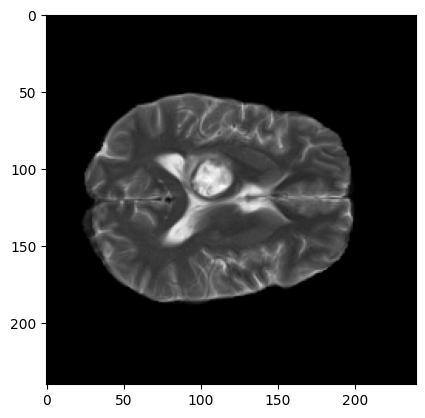

0.93417966
met
t2


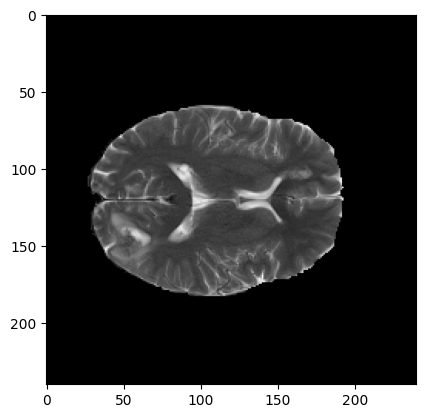

0.9293043
met
t2


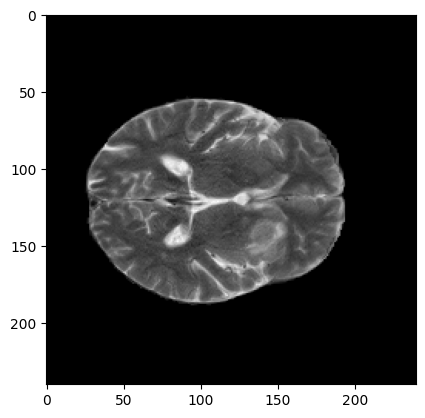

0.9291093
met
t2


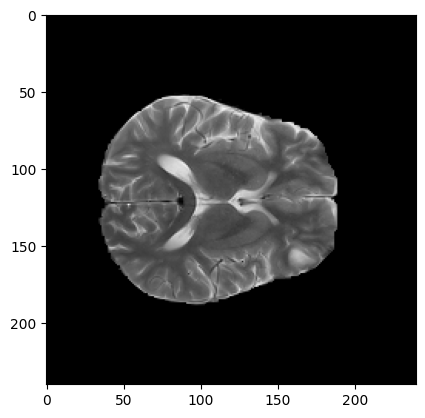

0.92694753
met
t2


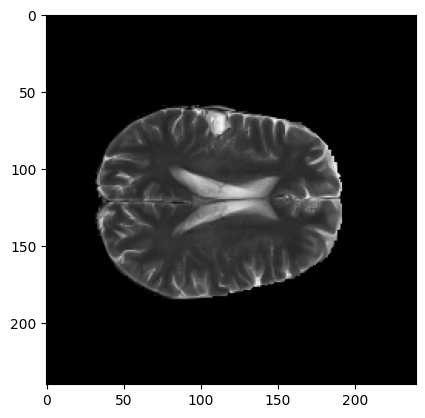

0.92642677
met
t2


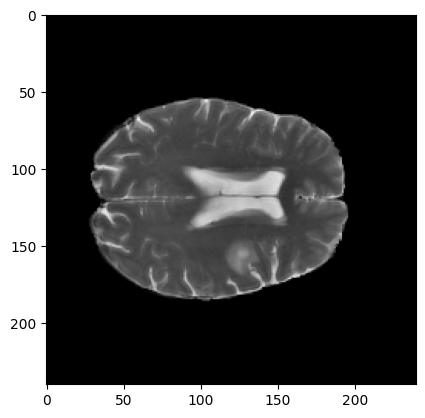

0.9260757
met
t2


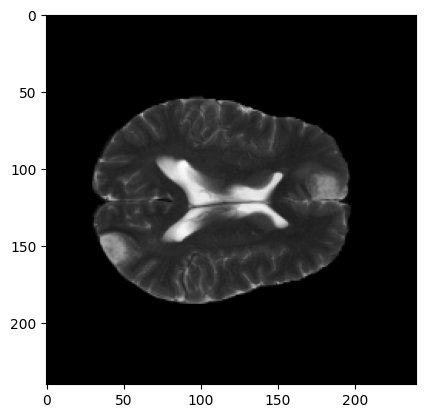

0.9238382
met
t2


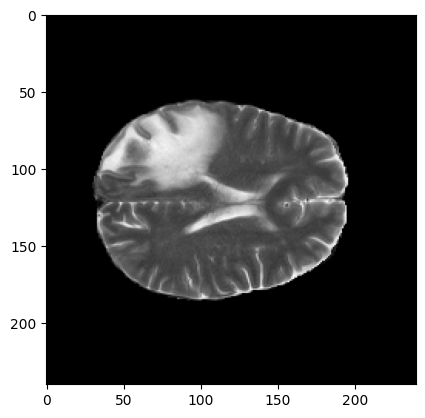

0.9224892
met
t2


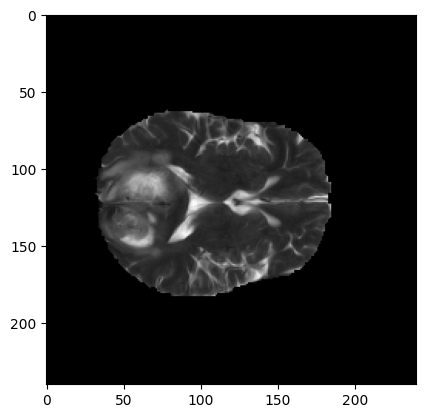

0.9124715
met
t2


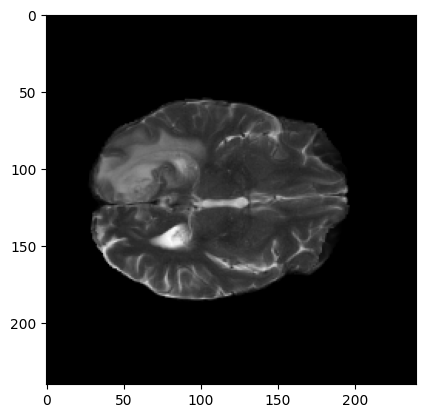

In [ ]:
# @title {run:'auto'}
# @markdown Forms support many types of fields.

filter_type = 't2'  # @param {type: "string"}
num_results = 10  # @param {type: "slider", min: 1, max: 20}
collection_name = "resnet152_imagenet_embeddings"

result = get_similar_embeddings(qdrant_client=qdrant_client,
                                collection_name=collection_name,
                                search_vector=query_data,
                                num_results=num_results,
                                filter_diagnose="met",
                                filter_image_type=filter_type
                                )

print(result)

for i in range(len(result)):
  res = result[i]
  print(res.score)
  #print(res.payload["bucket_url"],res.payload["patient_id"])
  print(res.payload["diagnose"])
  filter = res.payload["image_type"]
  print(filter)
  show_image_from_qdrant_result(google_client,res,filter)
